##**Problem Statements:**

###**1: Group customers based on similar financial behavior, needs, and characteristics using clustering techniques.**
###**2: Create marketing strategies tailored to each segment's preferences and interests.**
###**3: Develop and offer banking products and services that cater specifically to the unique needs of each customer segment.**
###**4: Optimize the delivery of banking services through preferred channels (e.g., mobile, online, branches) based on the habits of each segment.**
###**5: Improve customer satisfaction by providing personalized services and support, tailored to the preferences of each segment.**


##**Analytics Solution:**

###**By applying machine learning models, specifically clustering algorithms like K-means, we can segment customers based on their financial behavior and characteristics. This will allow the bank to tailor services, improve marketing strategies, and manage risks more effectively.**


##**Data Used**

In [ ]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder \
   .appName("linear_regression") \
   .getOrCreate()

train_data = spark.read.format("csv") \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .load("file:///content/drive/MyDrive/archive (5)/nepali/financial_loan.csv")

train_data.show(5)



+-------+-------------+----------------+----------+--------------------+-----+--------------+----------+---------------------+-----------------+-----------+-----------------+---------+-------+---------+----------+-------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|     id|address_state|application_type|emp_length|           emp_title|grade|home_ownership|issue_date|last_credit_pull_date|last_payment_date|loan_status|next_payment_date|member_id|purpose|sub_grade|      term|verification_status|annual_income|   dti|installment|int_rate|loan_amount|total_acc|total_payment|
+-------+-------------+----------------+----------+--------------------+-----+--------------+----------+---------------------+-----------------+-----------+-----------------+---------+-------+---------+----------+-------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|1077430|           GA|      INDIVIDUAL|  < 1 year|             

##**Input Variables Used**

In [24]:
from pyspark.sql import SparkSession

# Initialize a SparkSession
spark = SparkSession.builder.appName("Drop Columns Example").getOrCreate()

# Sample DataFrame for illustration (assuming train_data is your DataFrame)


columns = [
    'id', 'address_state', 'application_type', 'emp_length', 'emp_title', 'grade',
    'home_ownership', 'issue_date', 'last_credit_pull_date', 'last_payment_date',
    'loan_status', 'next_payment_date', 'member_id', 'purpose', 'sub_grade', 'term',
    'verification_status', 'annual_income', 'dti', 'installment', 'int_rate',
    'loan_amount', 'total_acc', 'total_payment'
]

# Drop the columns 'id' and date-related columns
columns_to_drop = ['id', 'issue_date', 'last_credit_pull_date', 'last_payment_date', 'next_payment_date','member_id']
cleaned_df = train_data.drop(*columns_to_drop)

# Display the modified DataFrame
cleaned_df.select('address_state',
 'application_type',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc',
 'total_payment').show(5)


+-------------+----------------+----------+--------------------+-----+--------------+-----------+-------+---------+----------+-------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|address_state|application_type|emp_length|           emp_title|grade|home_ownership|loan_status|purpose|sub_grade|      term|verification_status|annual_income|   dti|installment|int_rate|loan_amount|total_acc|total_payment|
+-------------+----------------+----------+--------------------+-----+--------------+-----------+-------+---------+----------+-------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|           GA|      INDIVIDUAL|  < 1 year|               Ryder|    C|          RENT|Charged Off|    car|       C4| 60 months|    Source Verified|      30000.0|  0.01|      59.83|  0.1527|       2500|        4|         1009|
|           CA|      INDIVIDUAL|   9 years|      MKC Accounting|    E|          RENT| Fully Paid|   

##**Data Preperation**

###**1: Remove Null value from all the columns**
###**2: Encode categorical features:**
Transform the "emp_length" column by replacing "10+ years" with 15, "< 1 year" with 5, and for all other values, use regexp_replace() to remove " years" or " year" and cast the result to an integer.
###**3: Data Transformation using String Indexer:**
String Indexer convert string categorical columns to numerical indices using StringIndexer for further processing in Spark ML.
###**4: Data Reduction:**
Remove unnecessary columns from a DataFrame that are not required for further processing





In [ ]:
cleaned_df = cleaned_df.na.drop(subset=[
'address_state',
 'application_type',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc',
 'total_payment'])

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, regexp_replace, col

# Create a SparkSession
spark = SparkSession.builder.appName("Transform emp_length").getOrCreate()



# Transform the emp_length column
transformed_df = cleaned_df.withColumn(
    "emp_length",
    when(col("emp_length") == "10+ years", 15)
    .when(col("emp_length") == "< 1 year", 5)
    .otherwise(regexp_replace(col("emp_length"), " years| year", "").cast("int"))
)

# Show the final DataFrame
transformed_df.select('emp_length').show(5)


+----------+
|emp_length|
+----------+
|         5|
|         9|
|         4|
|         5|
|        15|
+----------+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct

# Initialize a SparkSession
spark = SparkSession.builder.appName("Identify Categorical Columns").getOrCreate()

columns = [
  'address_state',
 'application_type',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc',
 'total_payment']

# Identify categorical columns based on data type and unique values
categorical_columns = []
for col_name, dtype in transformed_df.dtypes:
    if dtype == 'string':
        categorical_columns.append(col_name)
    elif dtype in ['int', 'double', 'float', 'long']:
        # Check the number of unique values in numeric columns to consider them as categorical
        unique_count = transformed_df.select(countDistinct(col(col_name))).collect()[0][0]
        if unique_count < 20:  # Arbitrary threshold for categorical
            categorical_columns.append(col_name)

#print("Categorical Columns:", categorical_columns)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder \
    .appName("StringIndexer Example") \
    .getOrCreate()

# Cast the necessary columns to string (if not already)
df = transformed_df.withColumn("address_state", col("address_state").cast("string")) \
                   .withColumn("application_type", col("application_type").cast("string"))\
                   .withColumn("emp_length", col("emp_length").cast("string")) \
                   .withColumn("emp_title", col("emp_title").cast("string")) \
                   .withColumn("grade", col("grade").cast("string")) \
                   .withColumn("home_ownership", col("home_ownership").cast("string")) \
                   .withColumn("loan_status", col("loan_status").cast("string")) \
                   .withColumn("purpose", col("purpose").cast("string")) \
                   .withColumn("sub_grade", col("sub_grade").cast("string")) \
                   .withColumn("term", col("term").cast("string")) \
                   .withColumn("verification_status", col("verification_status").cast("string"))

# Apply StringIndexer
indexer = StringIndexer(inputCols=["address_state", "application_type", "emp_length", "emp_title",
                                   "grade", "home_ownership", "loan_status", "purpose",
                                   "sub_grade", "term", "verification_status"],
                        outputCols=["address_state_indexed", "application_type_indexed",
                                    "emp_length_indexed", "emp_title_indexed", "grade_indexed",
                                    "home_ownership_indexed", "loan_status_indexed",
                                    "purpose_indexed", "sub_grade_indexed", "term_indexed",
                                    "verification_status_indexed"]).fit(df)

# Transform the DataFrame
indexed_df = indexer.transform(df)

# Rearrange columns to place indexed columns next to their original columns
for original_col, indexed_col in zip(indexer.getInputCols(), indexer.getOutputCols()):
    indexed_df = indexed_df.withColumn(indexed_col, col(indexed_col)).withColumnRenamed(indexed_col, original_col + "_indexed")

# Select the columns in the desired order
final_columns = []
for col_name in df.columns:
    final_columns.append(col_name)
    if col_name in indexer.getInputCols():
        final_columns.append(col_name + "_indexed")

# Display the final DataFrame
indexed_df = indexed_df.select(final_columns)
indexed_df.show(5)


+-------------+---------------------+----------------+------------------------+----------+------------------+--------------------+-----------------+-----+-------------+--------------+----------------------+-----------+-------------------+-------+---------------+---------+-----------------+----------+------------+-------------------+---------------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|address_state|address_state_indexed|application_type|application_type_indexed|emp_length|emp_length_indexed|           emp_title|emp_title_indexed|grade|grade_indexed|home_ownership|home_ownership_indexed|loan_status|loan_status_indexed|purpose|purpose_indexed|sub_grade|sub_grade_indexed|      term|term_indexed|verification_status|verification_status_indexed|annual_income|   dti|installment|int_rate|loan_amount|total_acc|total_payment|
+-------------+---------------------+----------------+------------------------+----------+------------------+---------

In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Column Selection and CSV Write") \
    .getOrCreate()

# Assuming your DataFrame is named 'indexed_df'
# Extract the desired columns
selected_columns = ['annual_income','dti','installment','int_rate','loan_amount', 'total_acc','total_payment','address_state_indexed',
 'application_type_indexed',
 'emp_length_indexed',
 'emp_title_indexed',
 'grade_indexed',
 'home_ownership_indexed',
 'loan_status_indexed',
 'purpose_indexed',
 'sub_grade_indexed',
 'term_indexed',
 'verification_status_indexed']
selected_df = indexed_df.select(selected_columns)

# Save the selected columns to a new CSV file
selected_df.write.csv('selected_data.csv', header=True, mode='overwrite')

# Stop the SparkSession













##**Exploratory Data Analysis (EDA)**

###**1:  Implement the Elbow method to determine the optimal number of clusters (k).**
  **WCSS:**
  Measure of variance within each clusters. Lower WCSS values indicate that the clusters are more compact and the data points within each cluster are closer to the centroid, suggesting better clustering.

  **Elbow Point:**
  The point where adding more clusters results in diminishing returns, indicating the optimal k.

  **In These case, the plot suggests that 3 clusters might be the optimal choice for these dataset.**

















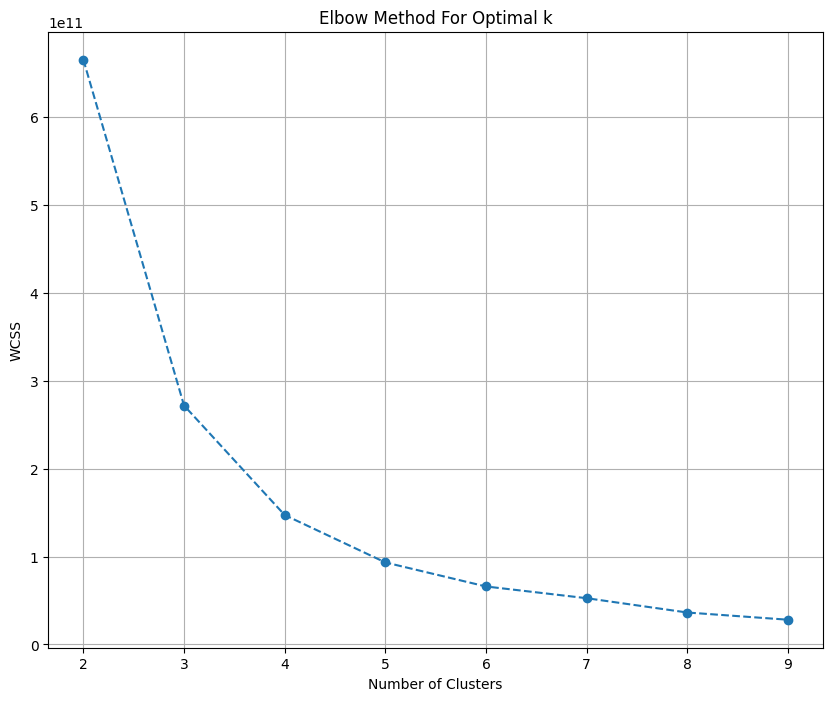

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("KMeans Elbow Method").getOrCreate()

# Load data
data = spark.read.csv('file:///content/selected_data.csv', header=True, inferSchema=True)

# Specify numerical and categorical columns
numerical_cols = [
    'annual_income', 'dti', 'installment', 'int_rate', 'loan_amount',
    'total_acc', 'total_payment'
]

categorical_cols = ['application_type_indexed',
 'emp_length_indexed',
 'emp_title_indexed',
 'grade_indexed',
 'home_ownership_indexed',
 'loan_status_indexed',
 'purpose_indexed',
 'sub_grade_indexed',
 'term_indexed',
 'verification_status_indexed'

]

# Assemble numerical columns into a feature vector
assembler_num = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
assembled_data_num = assembler_num.transform(data)

# Scale the numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
scaler_model = scaler.fit(assembled_data_num)
scaled_data_num = scaler_model.transform(assembled_data_num)

# Combine scaled numerical features with categorical features
assembler_all = VectorAssembler(inputCols=['scaled_numerical_features'] + categorical_cols, outputCol="features")
final_data = assembler_all.transform(scaled_data_num)

# Elbow method to find the optimal number of clusters
wcss = []
k_values = range(2, 10)  # Start k from 2 instead of 1

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol='features')
    model = kmeans.fit(final_data)
    wcss.append(model.summary.trainingCost)

# Plot the elbow method graph
plt.figure(figsize=(10, 8))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()



###**2: Calculates the mean of numerical features and the mode (most frequent value) of categorical features for each cluster.**

















In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, count, desc, mean, first

# Initialize Spark session
spark = SparkSession.builder.appName("KMeans Clustering Mean and Mode").getOrCreate()


# Load data
data = spark.read.csv('file:///content/selected_data.csv', header=True, inferSchema=True)

# Specify the input columns
input_columns = [
    'annual_income',
    'dti',
    'installment',
    'int_rate',
    'loan_amount',
    'total_acc',
    'total_payment',
    'address_state_indexed',
    'application_type_indexed',
    'emp_length_indexed',
    'emp_title_indexed',
    'grade_indexed',
    'home_ownership_indexed',
    'loan_status_indexed',
    'purpose_indexed',
    'sub_grade_indexed',
    'term_indexed',
    'verification_status_indexed',

]

# Assemble input columns into a feature vector
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
assembled_data = assembler.transform(data)

# Scale the data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Apply K-means clustering
kmeans = KMeans(k=3, seed=42, featuresCol='scaled_features')
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)

# Select numerical and categorical columns
numerical_columns = [
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc',
 'total_payment',]
categorical_columns = ['emp_title_indexed','purpose_indexed','term_indexed','loan_status_indexed','verification_status_indexed','address_state_indexed', 'application_type_indexed', 'grade_indexed','sub_grade_indexed', 'emp_length_indexed', 'home_ownership_indexed']

# Calculate mean for numerical columns within each cluster
mean_df = predictions.groupBy("prediction").agg(
    *[mean(col).alias(f'mean_{col}') for col in numerical_columns]
)

# Show mean results
#mean_df.show()

# Calculate mode for categorical columns within each cluster
for col_name in categorical_columns:
    mode_df = predictions.groupBy("prediction", col_name).agg(count(col_name).alias('count')) \
        .orderBy('prediction', desc('count')) \
        .groupBy("prediction") \
        .agg(first(col_name).alias(f'mode_{col_name}'))

    # Show mode results
    #mode_df.show()

# Merge mean and mode results
result_df = mean_df
for col_name in categorical_columns:
    mode_df = predictions.groupBy("prediction", col_name).agg(count(col_name).alias('count')) \
        .orderBy('prediction', desc('count')) \
        .groupBy("prediction") \
        .agg(first(col_name).alias(f'mode_{col_name}'))

    result_df = result_df.join(mode_df, on="prediction")

# Show final result
result_df.show()


+----------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+----------------------+--------------------+-----------------+------------------------+--------------------------------+--------------------------+-----------------------------+------------------+----------------------+-----------------------+---------------------------+
|prediction|mean_annual_income|           mean_dti|  mean_installment|      mean_int_rate|  mean_loan_amount|    mean_total_acc|mean_total_payment|mode_emp_title_indexed|mode_purpose_indexed|mode_term_indexed|mode_loan_status_indexed|mode_verification_status_indexed|mode_address_state_indexed|mode_application_type_indexed|mode_grade_indexed|mode_sub_grade_indexed|mode_emp_length_indexed|mode_home_ownership_indexed|
+----------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+---------------


## **Model Preperation:**

###**1: VectorAssembler to transform feature columns into a single vector column named "features".**
###**2: Data Normalization:**
   Data normalization is a preprocessing step used to rescale feature values to a common range, typically [0, 1] or [-1, 1]
###**3: Splitting the data into 80% training and 20% testing sets.**
###**4: Principal Component Analysis (PCA) :**
  Reduce the dimensionality of a dataset
###**5: Model:**
K-means Clustering
###**6: Number of clusters (k): 3**



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.sql.functions import rand

# Create a SparkSession
spark = SparkSession.builder.appName("Customer_segmentation").getOrCreate()

# Load the data
loan_data = spark.read.csv("selected_data.csv", header=True, inferSchema=True)

# List of numerical and categorical feature columns
numerical_cols = ['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']
categorical_cols = ['address_state_indexed', 'application_type_indexed', 'emp_length_indexed',
                    'emp_title_indexed', 'grade_indexed', 'home_ownership_indexed',  'loan_status_indexed', 'purpose_indexed', 'sub_grade_indexed',
                    'term_indexed', 'verification_status_indexed']

# Assemble the numerical features
assembler_num = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
assembled_data_num = assembler_num.transform(loan_data)

# Normalize the numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withStd=True, withMean=False)
scaler_model = scaler.fit(assembled_data_num)
scaled_data_num = scaler_model.transform(assembled_data_num)

# Combine the scaled numerical features with categorical features
assembler_all = VectorAssembler(inputCols=['scaled_numerical_features'] + categorical_cols, outputCol="features")
final_data = assembler_all.transform(scaled_data_num)

# Split the data into training and testing sets
final_data = final_data.withColumn("rand", rand())
final_data = final_data.orderBy("rand")
training_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

# Apply PCA for dimensionality reduction
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(training_data)
training_data_pca = pca_model.transform(training_data)
test_data_pca = pca_model.transform(test_data)

# Train the K-Means model on the PCA-transformed data
kmeans = KMeans(k=3, featuresCol="pca_features", predictionCol="cluster")
kmeans_model = kmeans.fit(training_data_pca)



##**Prediction Part**

###**1. Perform clustering using k=3 on testing datasets**

In [ ]:
predictions = kmeans_model.transform(test_data_pca)

# Show some predictions
predictions.select('cluster','annual_income',
    'dti',
    'installment',
    'int_rate',
    'loan_amount',
    'total_acc',
    'total_payment',
    'address_state_indexed',
    'application_type_indexed',
    'emp_length_indexed',
    'emp_title_indexed',
    'grade_indexed',
    'home_ownership_indexed',
    'loan_status_indexed',
    'purpose_indexed',
    'sub_grade_indexed',
    'term_indexed',
    'verification_status_indexed').show(5)

predictions.select('cluster','scaled_numerical_features','features','pca_features').show(5)

+-------+-------------+------+-----------+--------+-----------+---------+-------------+---------------------+------------------------+------------------+-----------------+-------------+----------------------+-------------------+---------------+-----------------+------------+---------------------------+
|cluster|annual_income|   dti|installment|int_rate|loan_amount|total_acc|total_payment|address_state_indexed|application_type_indexed|emp_length_indexed|emp_title_indexed|grade_indexed|home_ownership_indexed|loan_status_indexed|purpose_indexed|sub_grade_indexed|term_indexed|verification_status_indexed|
+-------+-------------+------+-----------+--------+-----------+---------+-------------+---------------------+------------------------+------------------+-----------------+-------------+----------------------+-------------------+---------------+-----------------+------------+---------------------------+
|      0|       4800.0|   0.0|      62.26|  0.1484|       1800|       10|         2221| 

In [ ]:
# Register the DataFrame as a temporary view
predictions.createOrReplaceTempView("predictions")

# Use Spark SQL to count the occurrences of each unique value in the 'cluster' column
unique_counts = spark.sql("SELECT cluster, COUNT(*) AS count FROM predictions GROUP BY cluster")

# Show the result
unique_counts.show()


+-------+-----+
|cluster|count|
+-------+-----+
|      1| 4727|
|      2| 3129|
|      0| 3122|
+-------+-----+



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

###**2. Model Evaluation**
A higher silhouette score indicates better-defined clusters, with points in the same cluster being more similar to each other than to points in other clusters.





In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate the model using silhouette score
evaluator = ClusteringEvaluator(predictionCol="cluster", featuresCol="pca_features", metricName="silhouette")
silhouette_score = evaluator.evaluate(predictions)

print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.7950847079349905


###**3. Visualization of Cluster with Centroid**

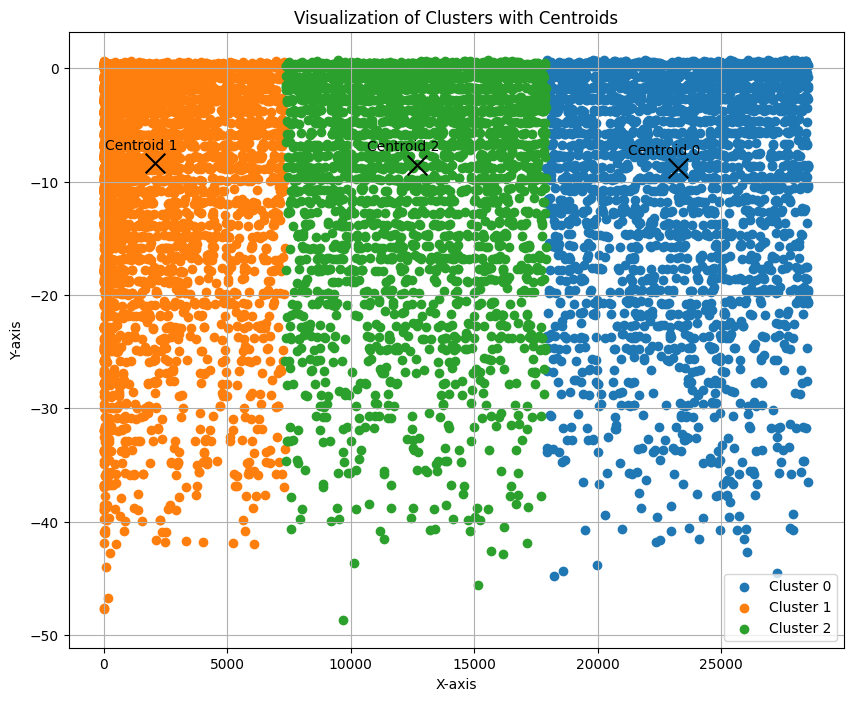

In [ ]:
import numpy as np

# Extract features and cluster assignments from predictions DataFrame
features = predictions.select("pca_features").collect()
clusters = predictions.select("cluster").collect()

x_values = [feature[0][0] for feature in features]
y_values = [feature[0][1] for feature in features]

plt.figure(figsize=(10, 8))
for i in range(3):
    cluster_x = [x_values[j] for j in range(len(clusters)) if clusters[j][0] == i]
    cluster_y = [y_values[j] for j in range(len(clusters)) if clusters[j][0] == i]
    plt.scatter(cluster_x, cluster_y, label=f'Cluster {i}')

    # Compute the centroid of the current cluster
    centroid_x = np.mean(cluster_x)
    centroid_y = np.mean(cluster_y)
    plt.scatter(centroid_x, centroid_y, color='black', marker='x', s=200)  # Mark centroid with a black 'x'

    # Annotate the centroid with its cluster number
    plt.annotate(f'Centroid {i}', (centroid_x, centroid_y), textcoords="offset points", xytext=(-10,10), ha='center')

plt.title('Visualization of Clusters with Centroids')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()


##**Business Translation**

###**1: For Marketing:**
Tailor ads to match the interests and preferences of each customer group.
###**2: For Product Development:**
Create or modify products to better meet the needs of each segment.
###**3: For Risk Management:**
 Identify which groups might be risky and adjust lending policies accordingly.
###**4: For Customer Service:**
 Provide the best services for each group, making banking easier and more enjoyable for everyone.